In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


$$ P(\textrm{hypothesis} | \textrm{data}, I) = \dfrac{P(\textrm{data} | \textrm{hypothesis}, I) P(\textrm{hypothesis} | I)}{P(\textrm{data} | I)} $$

# 1. Fitting a line

In astronomy, a lot of information about the physical and emission properties of astronomical objects is accessed through spectroscopic measurements, i.e., the emission intensity as a function of wavelength/frequency. Interesting spectral features are emission or absorption lines. Naturally, the lines are not... lines, but narrow peaks! A true line is impossible due to quantum effects, but in addition, local/extended effects tend to "broaden" or alter the shape of spectal lines (e.g., thermal doppler, pressure, rotation of object, 

$$ 
y(x) = \dfrac{A}{1 + \left(\dfrac{x - x_0}{w}\right)^2}           \qquad \text{(Lorentzian or Cauchy model)}
$$

$$ 
y(x) = A \exp{\left[-\frac{\left(x - x_0\right)^2}{2 w^2}\right]} \qquad \text{(Gaussian or Normal model)}
$$


where 
* $A$ is the amplitude (notice that $y(x_0) = A$ in both cases), 
* $x_0$ is the location parameter (the center of the line), and
* $w$ is the "spread" or width of the line.


> Notice that here we use the word Cauchy and Gaussian to refer to non-linear models rather than distributions. Our data follows the shape of the PDFs of these distributions, not the distributions themselves!


Now, let's assume we have measured the intensitities $y_i$ at given (unitless) wavelengths $x_i$, and that the errors $e_i$ are normally distributed with standard deviation $\sigma$:

$$ y_i = y(x_i) + \epsilon_i, \qquad \epsilon_i \sim \text{Norm}(0, \sigma)$$

## 1.1. The data from an unknown distribution

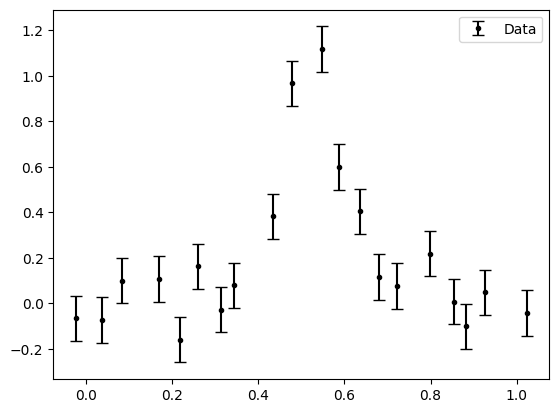

In [ ]:
np.random.seed(2025)

def make_data(x, model_dist, amplitude, location, width, error_scale=0.0):
    """Make a spectral line following the PDF of a given distribution.
    
    x           : the wavelength
    model_dist  : the distribution of which the PDF will be used
    amplitude   : the maximum height of the spectral line
    location    : the center of the spectral line
    width       : the width of the spectral line
    error_scale : the standard deviation of the observational uncertainties
    
    NOTE: use default `error_scale` (0.0) to get a model instead of an observational sample.
    
    """
    distribution = model_dist(loc=location, scale=width)
    y = distribution.pdf(x)
    y = amplitude * y / np.max(y)
    if error_scale > 0:
        y = np.random.normal(y, scale=error_scale)
    y_err = np.ones_like(y) * error_scale
    return y, y_err


n_data = 20

# two potential distributions
model_distributions = [st.cauchy, st.norm]
model_distributions_names = ["Cauchy", "Normal"]

# select pseudo-randomly the true distribution
random_index = 2023 % 17 % 2
true_model_distribution = model_distributions[random_index]
true_model_distribution_name = model_distributions_names[random_index]

# Permitted ranges for the parameters (because we processed the data and we have some intuition)
MIN_AMPLITUDE = 0.9
MAX_AMPLITUDE = 1.1
MIN_LOCATION = 0.45
MAX_LOCATION = 0.55
MIN_WIDTH = 0.05
MAX_WIDTH = 0.15

# Select the true parameters (these are supposed to be hidden from us)
true_amplitude = np.random.uniform(MIN_AMPLITUDE, MAX_AMPLITUDE)
true_location = np.random.uniform(MIN_LOCATION, MAX_LOCATION)
true_width = np.random.uniform(MIN_WIDTH, MAX_WIDTH)

# Make the new data according to the true model
x_data = np.linspace(0.0, 1.0, n_data) + np.random.uniform(-0.5/n_data, 0.5/n_data, size=n_data)
y_data, e_data = make_data(x_data, true_model_distribution, amplitude=true_amplitude, location=true_location, width=true_width, error_scale=0.1)

# Plot them!
plt.figure()
plt.errorbar(x_data, y_data, yerr=e_data, fmt="k.", capsize=4, label="Data")
plt.legend(loc="upper right")
plt.show()

## 1.2. Overplotting two potential models using fiducial parameters

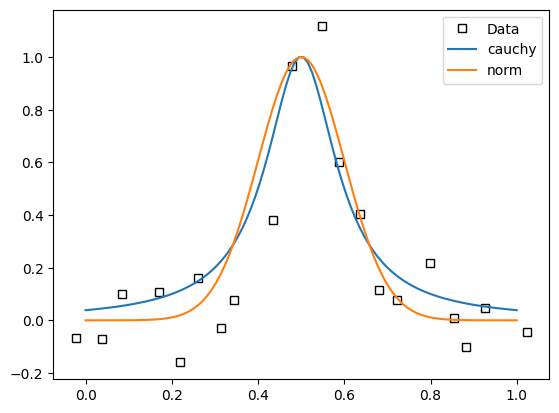

In [3]:
# use the midpoints of the permitted ranges of the parameters
fiducial_amplitude = (MIN_AMPLITUDE + MAX_AMPLITUDE) / 2.0
fiducial_location = (MIN_LOCATION + MAX_LOCATION) / 2.0
fiducial_width = (MIN_WIDTH + MAX_WIDTH) / 2.0

plt.figure()
plt.plot(x_data, y_data, "ks", mfc="none", label="Data")

for model_distribution in model_distributions:
    x_plot = np.linspace(0, 1, 100)
    y_plot, _ = make_data(x_plot, 
                          model_distribution,            # try this model
                          amplitude=fiducial_amplitude,  # fiducial...
                          location=fiducial_location,    # ...parameters...
                          width=fiducial_width,          # ...from ranges
                          error_scale=0.0                # the prediction does not have uncertainty
                         )
    plt.plot(x_plot, y_plot, label=model_distribution.name)

plt.legend(loc="upper right")
plt.show()

<font size=3><u>**In-class discussion: The plotted models use fiducial values for the parameters. However to you think one fits best than the other?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
It's purely subjective at this point!
<br>
    

# 1.3. Defining the prior, likelihood and posterior assuming Gaussian profile...

**Reminder**: we operate in log-space (log-prior, log-likelihood, log-posterion) for numerical reasons.

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:**  Complete the functions. Hint: the `make_data` function can be used to get model predictions as well! 
    
**Warning**: the function returns two things!
</div>

**(Reminder) From cell above:**
```python
# Permitted ranges for the parameters (because we processed the data and we have some intuition)
MIN_AMPLITUDE = 0.9
MAX_AMPLITUDE = 1.1
MIN_LOCATION = 0.45
MAX_LOCATION = 0.55
MIN_WIDTH = 0.05
MAX_WIDTH = 0.15

# Our observed data
x_data = np.linspace(0.0, 1.0, n_data) + np.random.uniform(-0.5/n_data, 0.5/n_data, size=n_data)
y_data, e_data = make_data(x_data, true_model_distribution, amplitude=true_amplitude, location=true_location, width=true_width, error_scale=0.1)
```

**(Reminder): From MLE notebook:**

Under the assumption of Gaussian uncertainties and independence of data,
$$
\ln L = \text{constant} - \frac{1}{2} \sum_{i=1}^{N} {\dfrac{(y_i-f(x_i))^2}{\sigma_i^2}} = \text{constant} - \frac{\chi^2}{2}
$$


In [4]:
def ln_prior(amplitude, location, width):
    if MIN_AMPLITUDE < amplitude < MAX_AMPLITUDE and MIN_LOCATION < location < MAX_LOCATION and MIN_WIDTH < width < MAX_WIDTH:
        return 0.0
    return -np.inf

def ln_likelihood_norm(amplitude, location, width):
    y_pred, _ = make_data(x_data, model_dist=st.norm, amplitude=amplitude, location=location, width=width)
    chi2 = np.sum((y_data - y_pred) ** 2.0 / e_data ** 2.0)
    return -chi2 / 2.0

def ln_posterior_norm(amplitude, location, width):
    return ln_prior(amplitude, location, width) + ln_likelihood_norm(amplitude, location, width)

# 1.4. Maximizing the posterior

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Tasks:**
1. Define the function to be minimized in order to maximize the posterior.
2. Choose appropriate starting values for the minimization routine.
</div>

In [5]:
def neg_ln_posterior_norm(theta):
    amplitude, location, width = theta
    return -ln_posterior_norm(amplitude=amplitude, location=location, width=width)

min_result_norm = minimize(neg_ln_posterior_norm, x0=[fiducial_amplitude, fiducial_location, fiducial_width], method='Nelder-Mead')
est_amplitude, est_location, est_width = min_result_norm.x


print(min_result_norm)
print()
print("| PARAMETER  |  ESTIMATION  |  TRUTH  |")
print(f"| amplitude  | {est_amplitude:11.3f}  | {true_amplitude:6.3f}  |")
print(f"| location   | {est_location:11.3f}  | {true_location:6.3f}  |")
print(f"| width      | {est_width:11.3f}  | {true_width:6.3f}  |")
print()
print("At best-fitting values...")
lnL_norm = ln_likelihood_norm(*min_result_norm.x)
lnP_norm = ln_posterior_norm(*min_result_norm.x)
print(f"  * log-prior      : {ln_prior(*min_result_norm.x):.6f}")
print(f"  * log-likelihood : {lnL_norm:.6f}")
print(f"  * log-posterior  : {lnP_norm:.6f}")

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 10.027436499340382
             x: [ 1.068e+00  5.244e-01  6.749e-02]
           nit: 66
          nfev: 122
 final_simplex: (array([[ 1.068e+00,  5.244e-01,  6.749e-02],
                       [ 1.068e+00,  5.244e-01,  6.749e-02],
                       [ 1.068e+00,  5.244e-01,  6.750e-02],
                       [ 1.068e+00,  5.244e-01,  6.750e-02]]), array([ 1.003e+01,  1.003e+01,  1.003e+01,  1.003e+01]))

| PARAMETER  |  ESTIMATION  |  TRUTH  |
| amplitude  |       1.068  |  1.018  |
| location   |       0.524  |  0.520  |
| width      |       0.067  |  0.069  |

At best-fitting values...
  * log-prior      : 0.000000
  * log-likelihood : -10.027436
  * log-posterior  : -10.027436


<font size=3><u>**In-class discussion: The fit was successful and we got parameters close to the truth. Is the Gaussian model validated?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
As in hypothesis testing, the model is assumed to be true. The fitting process does not validate the model. The value of the log-posterior does not convey any information regarding the validity of the model.
<br>
    

## 1.5. Repeating using a Cauchy profile

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Tasks:**  Do the same steps for the Cauchy profile.
    
1. Complete the functions.
2. Choose appropriate starting values for the minimization routine.
</div>

In [6]:
def ln_likelihood_cauchy(amplitude, location, width):
    y_pred, _ = make_data(x_data, model_dist=st.cauchy, amplitude=amplitude, location=location, width=width)
    chi2 = np.sum((y_data - y_pred) ** 2.0 / e_data ** 2.0)
    return -chi2 / 2.0

def ln_posterior_cauchy(amplitude, location, width):
    return ln_prior(amplitude, location, width) + ln_likelihood_cauchy(amplitude, location, width)

def neg_ln_posterior_cauchy(theta):
    amplitude, location, width = theta
    return -ln_posterior_cauchy(amplitude=amplitude, location=location, width=width)

min_result_cauchy = minimize(neg_ln_posterior_cauchy, x0=[fiducial_amplitude, fiducial_location, fiducial_width], method='Nelder-Mead')
est_amplitude, est_location, est_width = min_result_cauchy.x

print(min_result_cauchy)
print()
print("| PARAMETER  |  ESTIMATION  |  TRUTH  |")
print(f"| amplitude  | {est_amplitude:11.3f}  | {true_amplitude:6.3f}  |")
print(f"| location   | {est_location:11.3f}  | {true_location:6.3f}  |")
print(f"| width      | {est_width:11.3f}  | {true_width:6.3f}  |")
print()
print("At best-fitting values...")
lnL_cauchy = ln_likelihood_cauchy(*min_result_cauchy.x)
lnP_cauchy = ln_posterior_cauchy(*min_result_cauchy.x)
print(f"  * log-prior      : {ln_prior(*min_result_cauchy.x):.6f}")
print(f"  * log-likelihood : {lnL_cauchy:.6f}")
print(f"  * log-posterior  : {lnP_cauchy:.6f}")

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 8.666009497316683
             x: [ 1.100e+00  5.196e-01  5.715e-02]
           nit: 93
          nfev: 164
 final_simplex: (array([[ 1.100e+00,  5.196e-01,  5.715e-02],
                       [ 1.100e+00,  5.196e-01,  5.715e-02],
                       [ 1.100e+00,  5.196e-01,  5.712e-02],
                       [ 1.100e+00,  5.196e-01,  5.724e-02]]), array([ 8.666e+00,  8.666e+00,  8.666e+00,  8.666e+00]))

| PARAMETER  |  ESTIMATION  |  TRUTH  |
| amplitude  |       1.100  |  1.018  |
| location   |       0.520  |  0.520  |
| width      |       0.057  |  0.069  |

At best-fitting values...
  * log-prior      : 0.000000
  * log-likelihood : -8.666009
  * log-posterior  : -8.666009


<font size=3><u>**In-class discussion: What can you infer from the comparison between the resulting when assuming normal vs. Cauchy?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
The parameters are in both cases close to the truth. Whether they are closer or not, in practice, we cannot use in real data because we don't know the truth!
The likelihood and posterior is, however, different! Maybe we can use this?
<br>

# 2. Selecting models

If we don't know the correct model for the data ($D$), then we have a model selection problem. We should come up with all potential models, or at least those expected from our prior experience with the data and the underlying mechanisms decribing them.

In the case above we have the Normal and Cuachy model. Let's name them A and B respectively. We can compare the posteriors by taking their ratio:

Posterior odds: $ \dfrac{P(A|D)}{P(B|D)} $

Using the Bayes rule we can express it in the following way:

$$ \dfrac{P(A|D)}{P(B|D)} = \dfrac{P(D|A)P(A) / P(D)}{P(D|B)P(B) / P(D)} = \dfrac{P(D|A)P(A)}{P(D|B)P(B)}$$

## 2.1. Likelihood ratio (prior-independent)

As we can see, the results depend on our prior belief on the models. In many cases, we want to be completely fair, and therefore we assign equal prior to both of them, resulting in:

$$ \dfrac{P(D|A)}{P(D|B)} $$

which is also used by **frequentists** under the name **likelihood ratio statistic**:

$$ \mathrm{LR}_{AB} = \dfrac{L_A}{L_B} = e^{l_A - l_B} $$

where the $l_A$ and $l_B$ are the log-likelihoods for convenience.

> The larger the likelihood ratio, the more preferred Model A is with respect to Model B


### Connection to comparison of $\chi^2$ values

Under the assumption of Gaussian errors, then our log-likelihood is: *(some constant)* $-\chi^2$. Therefore, if we compute the $\chi^2$ values of the best fitting parameters for our models A and B, then the likelihood ratio is:

$$ \mathrm{LR}_{AB} = e^{l_A - l_B} = e^{-\chi_A^2+\chi_B^2} $$

so the model with smallest $\chi^2$ is preferred.

## 2.2. Taking into account the flexibility of the models

In classical statistics, we don't compare $\chi^2$ values, but the **reduced-$\chi^2$** which is divided by the degrees of freedom (number of data point - number of model parameters) to penalize complicated models that can fit the data easily without necessarily being the true model. In Bayesian statistics there are varous tools:

### The Akaike Information Criterion

If we use a model to represent the data, we lose information! There is structure/noise/etc. that we have lost! AIC measures the amount of information that is lost, **relative to another model**.

A good model "extracts" or "represents" most of the information from a system, or... it maximizes its entropy! The AIC is the application of the Second Law of Thermodynamics on statistics using information theory (cf. *Shannon's information entropy*).

$$
\text{AIC} = 2k - 2\ln L
$$

where $k$ is the number of parameters of the model (if we had to estimate them from the data), and $L$ is the likelihood of the data according to the model.


> The larger the AIC, the more information is lost, so the worst for our model!



#### k is a penalty term

Using a 100-degree polynomial or a k-nearest neighbor interpolator, we could capture all trends in the data. However, this is just shifting all the information into parameters - it's not fair to compare something like that against a linear model!

### The Bayesian Information Criterion

$$
\text{BIC} = k \ln N - 2\ln L
$$

where $N$ is the size of the sample used to calculate the likelihood.

AIC vs. BIC: it's complicated...

> As in AIC, the larger the BIC, the more information is lost, so the worst for our model!



### Bayesian Factors

Like the likelihood ratio, but here, the likelihoods are not that of the best fit. It takes into account all possible values for the parameters (which can be different in each model), $\theta$!

$$
\text{K} = \dfrac{P(D|A)}{P(D|B)} = \dfrac{\int P(\theta_A) P(D|\theta_A, A) d\theta} {\int P(\theta_B) P(D|\theta_B, B) d\theta}
$$

> As in the likelihood ratio, the larger the value, the better for Model A compared to Model B!


### The Jeffreys' scale

| Bayes Factor | Strength of evidence |
| --- | --- |
|  1 - 3.2 | Not worth more than a bare mention |
|  3.2 - 10 | Substantial |
|  10 - 100 | Strong |
|  >100 | Decisive |


## 2.3. Let's compare the AICs, BICs

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:**  Calculate the AICs and BICs, and decide which model *won*!
</div>

In [7]:
AIC_norm = 2 * 3 - 2 * lnL_norm
AIC_cauchy = 2 * 3 - 2 * lnL_cauchy

BIC_norm = 2 * 3 * np.log(n_data) - 2 * lnL_norm
BIC_cauchy = 2 * 3 * np.log(n_data) - 2 * lnL_cauchy

print("AIC (norm, cauchy):", AIC_norm, AIC_cauchy)
print("BIC (norm, cauchy):", BIC_norm, BIC_cauchy)
print("Posterior ratio (norm / cauchy)  =", np.exp(lnP_norm - lnP_cauchy))
print("Posterior ratio (cauchy / norm)  =", np.exp(lnP_cauchy - lnP_norm))

print("And the truth is.... (drum roll)... The", true_model_distribution_name, "distribution!")

AIC (norm, cauchy): 26.054872998680764 23.332018994633366
BIC (norm, cauchy): 38.02926664000471 35.306412635957315
Posterior ratio (norm / cauchy)  = 0.25629478270481293
Posterior ratio (cauchy / norm)  = 3.9017571463861915
And the truth is.... (drum roll)... The Cauchy distribution!


# 3. Helping model selection

<font size=3><u>**In-class discussion: What could you change to increase the contrast between the models??**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
Since the models cannot change, data have to. Only if we get more data we can be more confident in selecting models. Increase the size of the synthetic data and try again!
<br>

# 4. Computing the Bayes Factor

Bayes Factors are agnostic about the location of the posterior maximum! They use the *marginal likelihood* or the *evidence*: the integral of the likelihood over all possible values of the parameters.

This makes them hard to compute, especially in complex, multi-dimensional parameter spaces. Thankfully, there are techniques like **Monte Carlo integration** that can help us.

Essentially, instead of integrating a function over $x$, we use the sum of uniform samples of $x$:

$$ \int\limits_a^b f(x) dx \approx \frac{b-a}{N} \sum\limits_{i=1}^N f(x_i) $$

or in $k$ dimensions, a sum over the whole volume $V$ of the multi-dimensional parameter space $\Omega$:

$$ \int_\Omega f(\vec{x}) d\vec{x} \approx \frac{V}{N} \sum\limits_{i=1}^N f(\vec{x}_i)$$

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Tasks:**
    
1. Choose a sample size for the Monte Carlo calculation.
2. Calculate the Bayes factor.
3. Which model is preferred? Does this agree with AIC and BIC?
</div>

In [8]:
sample_size = 10000
amp_samples = np.random.uniform(MIN_AMPLITUDE, MAX_AMPLITUDE, size=sample_size)
loc_samples = np.random.uniform(MIN_LOCATION, MAX_LOCATION, size=sample_size)
wid_samples = np.random.uniform(MIN_WIDTH, MAX_WIDTH, size=sample_size)

# use no normalization factor (watch out for the NaNs)
# ln_norm_factor = 0.0
# use the first random point to get the normalization factor
ln_norm_factor = ln_likelihood_norm(amp_samples[0], loc_samples[0], wid_samples[0])
print("Normalization factor:", ln_norm_factor)

sum_norm = 0.0
sum_cauchy = 0.0

for amp, loc, wid in zip(amp_samples, loc_samples, wid_samples):
    sum_norm += np.exp(ln_likelihood_norm(amp, loc, wid) - ln_norm_factor)
    sum_cauchy += np.exp(ln_likelihood_cauchy(amp, loc, wid) - ln_norm_factor)
    
K = sum_norm / sum_cauchy
print(f"K (norm / cauchy): {K:.4g}")
print(f"K (cauchy / norm): {1.0/K:.4g}")

Normalization factor: -44.133886551975486
K (norm / cauchy): 0.4857
K (cauchy / norm): 2.059


### Warning: Numerical precision & machine $\epsilon$ (`eps`)

1. Probabilities (or their densities) can be very small numbers, especially when calculated away from the maxima. 
2. Likelihoods (and hence priors) can be even smaller if we have large datasets (because probabilities are multiplied). 

**Example**
It's not unconceivable to have log-likelihood values $\ln L_i \approx -10000$. If we need to do operations in the linear space, e.g., $L_i \approx e^{-10000}$ we will end up with a bunch of zeros due to the limited exponent range of floating-point numbers.

**Solution**: We can use a normalization factor that brings these numbers closer to 1. ***We need to be sure that we use the same factor accross all evaluations of the likelihoods/posteriors, and all models if we perform model comparisons***. This normalization factor can be the first number we obtain in our calculations,
$$\large L_i = L_1 \frac{L_i}{L_1} \propto e^{\ln L_i - \ln L_1}, $$
or perhaps the mean, or median, or minimum/maximum value we encountered (however this requires to save all values),
$$\large L_i \propto e^{\ln L_i - \max \{\ln L_i\}} $$

# 5. Discussion: Bayesian vs. Frequentist

<font size=3><u>**In-class discussion: What are the main differences between the two approaches? Which one we prefer in astronomy/cosmology?**</u><font>

## Connecting Bayesian Inference with Maximum Likelihood Estimation (MLE)

It's insightful to connect the Bayesian framework with the Maximum Likelihood Estimation (MLE) approach we've seen earlier. Recall that in MLE, we seek to find the parameter values $\theta_{MLE}$ that maximize the likelihood function $L(\theta | \text{data}) = P(\text{data} | \theta)$.

Bayes' Theorem states:
$$ P(\theta | \text{data}) = \frac{P(\text{data} | \theta) P(\theta)}{P(\text{data})} $$

If we assume a **uniform (flat) prior** for $\theta$, $P(\theta) = C$ (a constant), then the posterior probability becomes:
$$ P(\theta | \text{data}) \propto P(\text{data} | \theta) \times C \propto P(\text{data} | \theta) $$
In this specific case (uniform prior), maximizing the posterior probability $P(\theta | \text{data})$ is equivalent to maximizing the likelihood $P(\text{data} | \theta)$. Thus, the **Maximum A Posteriori (MAP)** estimate, $\theta_{MAP}$, coincides with the MLE estimate, $\theta_{MLE}$.

**Key Differences and Similarities:**

1.  **Role of Priors**: The most significant difference is the inclusion of priors $P(\theta)$ in Bayesian inference. MLE does not formally incorporate prior beliefs about the parameters. If the prior is not uniform, then $\theta_{MAP}$ will generally differ from $\theta_{MLE}$. The prior effectively pulls the MAP estimate away from the MLE estimate, towards regions of higher prior probability.
2.  **Output**: MLE provides a point estimate for the parameters (and confidence intervals are often derived using approximations based on the likelihood function's curvature). Bayesian inference provides a full posterior probability distribution for the parameters, which describes our complete state of knowledge (and uncertainty) about them. Credible regions are derived directly from this posterior.
3.  **Interpretation**: The interpretation of results differs. MLE is rooted in the frequentist idea of how often data like ours would be observed if a parameter had a certain value. Bayesian inference provides a probabilistic statement about the parameter itself, given the observed data and prior beliefs.
4.  **Small Data Sets**: With small datasets, the choice of prior can have a more noticeable impact on the posterior. As the amount of data increases, the likelihood term $P(\text{data} | \theta)$ tends to dominate the prior, and Bayesian results often converge towards MLE results (assuming the prior is not overly restrictive or zero in the region of high likelihood). This is known as the data overwhelming the prior.
5.  **Marginalization**: Bayesian methods naturally handle nuisance parameters (parameters that are part of the model but not of primary interest) by integrating them out of the posterior (marginalization). While MLE can sometimes be adapted for this, it's a more direct and principled process in Bayesian inference.

**Example: MLE for a Gaussian vs. Bayesian with Uniform Prior**

Let's revisit the example of estimating the mean $\mu$ of a Gaussian distribution from $N$ measurements $\{x_i\}$, assuming a known $\sigma$.
The likelihood is:
$$ L(\mu | \{x_i\}, \sigma) = P(\{x_i\} | \mu, \sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(-\frac{(x_i-\mu)^2}{2\sigma^2}\right) $$
Maximizing this likelihood (or its logarithm) gives the MLE estimate $\mu_{MLE} = \bar{x} = \frac{1}{N}\sum x_i$.

Now, consider a Bayesian approach with a uniform prior for $\mu$, $P(\mu|I) \propto C$.
The posterior is $P(\mu | \{x_i\}, \sigma, I) \propto P(\{x_i\} | \mu, \sigma, I)$.
The value of $\mu$ that maximizes this posterior (the MAP estimate) will be the same as $\mu_{MLE}$, i.e., $\bar{x}$.
However, the Bayesian approach also gives us a full posterior distribution for $\mu$. If we had used an informative Gaussian prior for $\mu$, the MAP estimate would be a precision-weighted average of the prior mean and the sample mean, and would differ from the MLE.

Let's illustrate with a simple code example where we have a few data points and compare the likelihood (which is proportional to the posterior with a flat prior) with a posterior resulting from an informative Gaussian prior.

MLE estimate for μ: 2.50


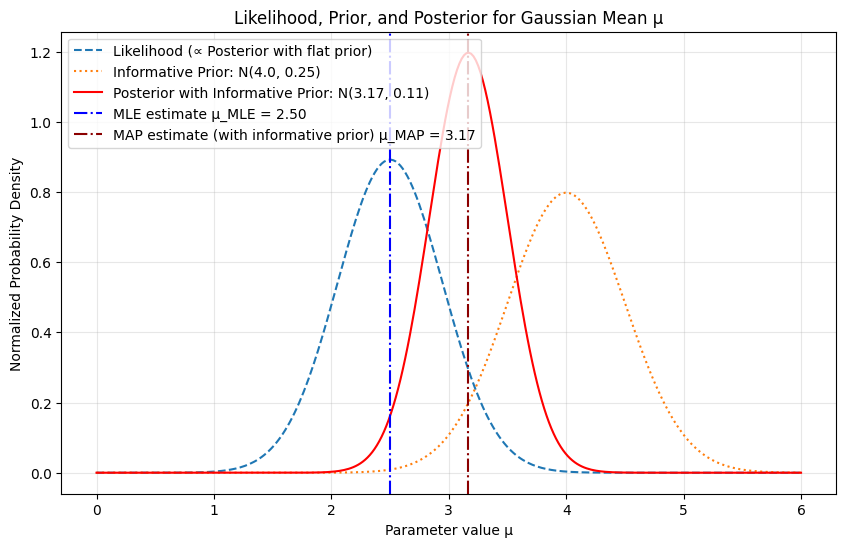

Posterior mean (MAP with Gaussian prior): 3.17


In [ ]:
# MLE vs Bayesian Example
np.random.seed(42)
data_points = np.array([1.5, 2.0, 2.5, 3.0, 3.5]) # Our observed data
sigma_known = 1.0 # Assume known standard deviation of measurements
N_data = len(data_points)

mu_mle = np.mean(data_points)
print(f"MLE estimate for μ: {mu_mle:.2f}")

# Define the likelihood function (proportional to posterior with flat prior)
def log_likelihood_gaussian(mu, data, sigma):
    return -N_data/2 * np.log(2 * np.pi * sigma**2) - np.sum((data - mu)**2) / (2 * sigma**2)

mu_values = np.linspace(0, 6, 300)
log_L_values = np.array([log_likelihood_gaussian(mu, data_points, sigma_known) for mu in mu_values])
L_values = np.exp(log_L_values - np.max(log_L_values)) # Normalize for plotting

# Define an informative Gaussian prior: P(μ|I) ~ N(μ_prior, σ_prior^2)
mu_prior, sigma_prior = 4.0, 0.5
prior_pdf_values = st.norm.pdf(mu_values, loc=mu_prior, scale=sigma_prior)

# Calculate the posterior: P(μ|data) ∝ Likelihood * Prior
# (For Gaussian likelihood and Gaussian prior, the posterior is also Gaussian)
# Effective data precision for the mean
data_precision = N_data / sigma_known**2
prior_precision = 1 / sigma_prior**2

posterior_variance = 1 / (data_precision + prior_precision)
posterior_mean = posterior_variance * (data_precision * mu_mle + prior_precision * mu_prior)
posterior_pdf_values = st.norm.pdf(mu_values, loc=posterior_mean, scale=np.sqrt(posterior_variance))

plt.figure(figsize=(10, 6))
plt.plot(mu_values, L_values / np.trapz(L_values, mu_values), label='Likelihood (∝ Posterior with flat prior)', linestyle='--')
plt.plot(mu_values, prior_pdf_values / np.trapz(prior_pdf_values, mu_values), label=f'Informative Prior: N({mu_prior}, {sigma_prior**2})', linestyle=':')
plt.plot(mu_values, posterior_pdf_values / np.trapz(posterior_pdf_values, mu_values), label=f'Posterior with Informative Prior: N({posterior_mean:.2f}, {posterior_variance:.2f})', color='red')
plt.axvline(mu_mle, color='blue', linestyle='-.', label=f'MLE estimate μ_MLE = {mu_mle:.2f}')
plt.axvline(posterior_mean, color='darkred', linestyle='-.', label=f'MAP estimate (with informative prior) μ_MAP = {posterior_mean:.2f}')
plt.title('Likelihood, Prior, and Posterior for Gaussian Mean μ')
plt.xlabel('Parameter value μ')
plt.ylabel('Normalized Probability Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Posterior mean (MAP with Gaussian prior): {posterior_mean:.2f}")

## Bayesian Credible Regions (or Intervals)

Once we have the posterior probability distribution $P(\text{hypothesis} | \text{data}, I)$, which tells us the probability of different parameter values (our hypothesis) given the data, we often want to summarize it.

*   **Point Estimates**: We might report the **Maximum A Posteriori (MAP)** value (the mode of the posterior), the **mean**, or the **median** of the posterior distribution as a single best guess for our parameter.

*   **Credible Regions**: More comprehensively, we define a **credible region** (or credible interval for a single parameter) that contains a certain amount of the posterior probability, for example, 90% or 95%.
    *   A $X\%$ credible region is an interval $[a, b]$ such that $\int_a^b P(\text{parameter} | \text{data}, I) d(\text{parameter}) = X/100$.
    *   **Interpretation**: A $X\%$ credible region means there is a $X\%$ probability that the true value of the parameter lies within that interval, given our data and model. This is a direct statement about the parameter's location.

**Crucial Distinction: Credible Regions vs. Frequentist Confidence Intervals**

This interpretation is fundamentally different from a frequentist confidence interval:
*   A **Bayesian $X\%$ credible region** is a statement about the probability of the parameter's value, given the observed data. The interval is fixed, and we assign a probability to the parameter being in it.
*   A **frequentist $X\%$ confidence interval** is constructed such that if we were to repeat the experiment many times, $X\%$ of such *calculated intervals* would contain the true, fixed parameter value. It's a statement about the long-run performance of the interval construction procedure, not directly about the probability of the parameter lying in a *specific, calculated* interval from our single dataset.
For scientists interpreting a single experiment, the Bayesian credible region often aligns more intuitively with the question: \"How likely is the parameter to be in this range, based on my data?\"

**Types of Credible Regions**

Credible regions are not unique. For a given probability level (e.g., 90%), common ways to define the interval include:
*   **Equal-Tailed Interval (or Central Credible Interval)**: This interval is defined by cutting off $(100-X)/2\%$ of the probability from each tail of the posterior distribution. For example, a 90% equal-tailed interval excludes 5% from the lower tail and 5% from the upper tail. This is often easy to compute.
*   **Highest Posterior Density (HPD) Interval**: This interval is constructed such that all points inside it have a higher posterior probability density than any point outside it. It is the shortest possible interval containing $X\%$ of the probability. While conceptually useful, it can be more complex to calculate, especially for asymmetric or multimodal posteriors.

For simplicity in our example, we will focus on the equal-tailed interval.

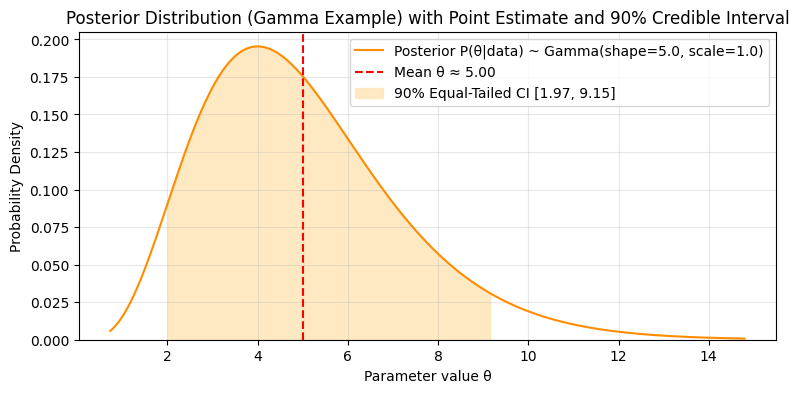

Assumed Posterior Distribution: Gamma(shape=5.0, scale=1.0)
Mean of the posterior (point estimate): 5.00
90% Equal-Tailed Credible Interval for θ: [1.97, 9.15]


In [ ]:
# Simple Example: Illustrating a Credible Interval
# Assume we have obtained a posterior distribution for a parameter θ.
# For this illustration, let's use a Gamma distribution as our posterior.
# P(θ|data, I) ~ Gamma(shape=a, scale=b)

shape_param = 5.0  # Example shape parameter for the Gamma posterior
scale_param = 1.0  # Example scale parameter for the Gamma posterior
# For scipy.stats.gamma, 'a' is the shape parameter. 'scale' is the scale parameter.
posterior_dist = st.gamma(a=shape_param, scale=scale_param)

# Values for plotting the PDF
# Plot from near 0 up to a high percentile to see the shape
theta_values = np.linspace(posterior_dist.ppf(0.001), posterior_dist.ppf(0.999), 300)
posterior_pdf_values = posterior_dist.pdf(theta_values)

plt.figure(figsize=(9, 4))
plt.plot(theta_values, posterior_pdf_values, label=f'Posterior P(θ|data) ~ Gamma(shape={shape_param:.1f}, scale={scale_param:.1f})', color='darkorange')

# Point Estimate: Mean of the posterior
mean_theta = posterior_dist.mean()
plt.axvline(mean_theta, color='red', linestyle='--', label=f'Mean θ ≈ {mean_theta:.2f}')

# 90% Equal-Tailed Credible Interval
confidence_level = 0.90
lower_bound, upper_bound = posterior_dist.interval(confidence_level)
plt.fill_between(theta_values, posterior_pdf_values,
                 where=(theta_values >= lower_bound) & (theta_values <= upper_bound),
                 color='moccasin', alpha=0.8,
                 label=f'{confidence_level*100:.0f}% Equal-Tailed CI [{lower_bound:.2f}, {upper_bound:.2f}]')

plt.title('Posterior Distribution (Gamma Example) with Point Estimate and 90% Credible Interval')
plt.xlabel('Parameter value θ')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)
plt.show()

print(f"Assumed Posterior Distribution: Gamma(shape={shape_param}, scale={scale_param})")
print(f"Mean of the posterior (point estimate): {mean_theta:.2f}")
print(f"{confidence_level*100:.0f}% Equal-Tailed Credible Interval for θ: [{lower_bound:.2f}, {upper_bound:.2f}]")

<table><tr>
<td> <img src="images/frequentists_vs_bayesians.png" style="height:700px;"/> </td>
<td> <img src="images/modified_bayes_theorem.png" style="height: 300px;"/> </td>
</tr></table>